In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F

## Loading the Data

In [7]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import SubjectLoader, MassDataset

In [57]:
num_subjects = 1
seed = 42
subject_loader = SubjectLoader(
        '/project/MASS/mass_spindles_dataset/subject_info.csv')
subjects = subject_loader.select_random_subjects(
        num_subjects=num_subjects, seed=seed)
dataset = MassDataset(
        '/project/MASS/mass_spindles_dataset',
        subjects=subjects,
        window_size=224,
        seq_len=1,
        seq_stride=25000,
        use_filtered=False,
        sampleable='both')


Time taken to load 01-03-0007: 1.9750134944915771
Time taken to create lookup table: 1.0273501873016357
Number of sampleable indices: 6323277
Number of spindles: 185476
Number of N1: 345000
Number of N2: 2812500
Number of N3: 1402500
Number of R: 1027500
Number of W: 720000


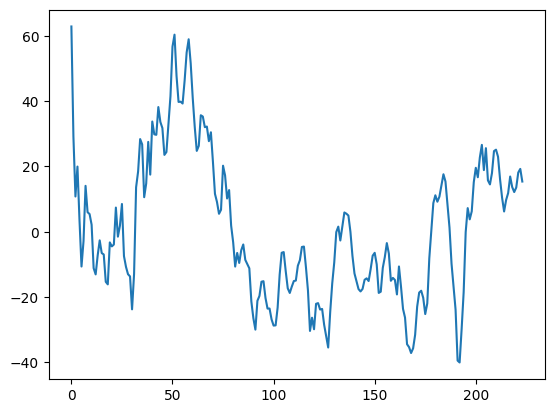

In [58]:
import matplotlib.pyplot as plt
plt.plot(dataset[4][0][0, 0, :])

## Morlet Wave Transformation to get Image

In [59]:
import numpy as np
import pywt
from torchvision.transforms.functional import to_pil_image
from transformers import ViTImageProcessor, ViTModel
import time
from scipy.signal import spectrogram
from portiloopml.portiloop_python.ANN.wamsley_utils import morlet_transform, _wmorlet
from scipy.signal import fftconvolve


In [71]:
import numpy as np
from scipy.signal import morlet
from torch.nn.functional import conv1d

# List of frequencies
n = 224
frequencies = np.array([i for i in range(1, n + 1)])  # replace with your frequencies

# Width
w = 100  # replace with your width

# Compute the Morlet wavelets
morlet = morlet(w, frequencies[:, np.newaxis])
# Remove the imaginary part
morlet = np.real(morlet)
morlet_waves = torch.from_numpy(morlet).unsqueeze(1).float()
data = dataset[4][0][0, :, :]

# Convolve the Morlet wavelets with your data
start = time.time()
output = conv1d(data, morlet_waves, padding='same')
end = time.time()
print(end - start)

0.005711555480957031


In [61]:
output.shape

torch.Size([224, 224])

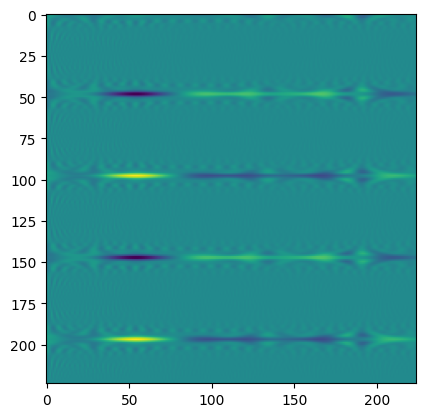

In [63]:
plt.imshow(output)

In [62]:
plt.plot(morlet_waves[1000, :])

IndexError: index 1000 is out of bounds for dimension 0 with size 224

In [91]:
wavelet = 'morl'
fs = 250  # Sampling frequency in hz
freq_num = 10  # Number of frequencies 
frequencies = [i for i in range(1, freq_num + 1)]
frequencies_norm = np.array(frequencies) / fs  # normalize
scales = pywt.frequency2scale(wavelet, frequencies_norm)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


In [87]:
scales

array([203.125     , 101.5625    ,  67.70833333,  50.78125   ,
        40.625     ,  33.85416667,  29.01785714,  25.390625  ,
        22.56944444,  20.3125    ,  18.46590909,  16.92708333,
        15.625     ,  14.50892857,  13.54166667,  12.6953125 ,
        11.94852941,  11.28472222,  10.69078947,  10.15625   ,
         9.67261905,   9.23295455,   8.83152174,   8.46354167,
         8.125     ,   7.8125    ,   7.52314815,   7.25446429,
         7.00431034,   6.77083333,   6.55241935,   6.34765625,
         6.15530303,   5.97426471,   5.80357143,   5.64236111,
         5.48986486,   5.34539474,   5.20833333,   5.078125  ,
         4.95426829,   4.83630952,   4.72383721,   4.61647727,
         4.51388889,   4.41576087,   4.32180851,   4.23177083,
         4.14540816,   4.0625    ,   3.98284314,   3.90625   ,
         3.83254717,   3.76157407,   3.69318182,   3.62723214,
         3.56359649,   3.50215517,   3.44279661,   3.38541667,
         3.32991803,   3.27620968,   3.22420635,   3.17

In [92]:
import time

def tensor2img(tensor):
    start_time = time.time()

    tensor_wt, _ = pywt.cwt(tensor[0, 0, :].cpu().numpy(), scales, wavelet, method='conv')
    print(f"Time for inverse wavelet transform: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = np.expand_dims(tensor_wt, axis=-1)
    print(f"Time for adding an axis: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = (((tensor_wt - tensor_wt.min()) / tensor_wt.max()) * 255).astype(np.uint8)
    print(f"Time for standardizing the data: {time.time() - start_time}")

    plt.imshow(tensor_wt[:, :, 0])

    start_time = time.time()
    tensor_wt = np.repeat(tensor_wt, 3, axis=-1)
    print(f"Time for converting to RGB: {time.time() - start_time}")

    start_time = time.time()
    image = to_pil_image(tensor_wt, mode='RGB')
    print(f"Time for converting to PIL image: {time.time() - start_time}")

    start_time = time.time()
    image =  processor(image, return_tensors='pt')['pixel_values']
    print(f"Time for image processing: {time.time() - start_time}")

    return image

Time for inverse wavelet transform: 0.003498554229736328
Time for adding an axis: 8.344650268554688e-05
Time for standardizing the data: 0.0005507469177246094
Time for converting to RGB: 2.2649765014648438e-05
Time for converting to PIL image: 0.0004780292510986328
Time for image processing: 0.04033470153808594
31.5802001953125


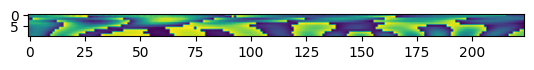

In [93]:
start = time.time()
img = tensor2img(dataset[0][0])
end = time.time()
print((end - start) * 512)

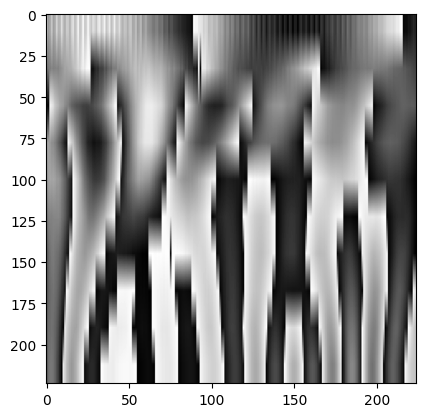

In [94]:
plt.imshow(img[0, 0, :, :], cmap='gray')

## Trying STFT

In [142]:
def tensor2img(tensor):
    start_time = time.time()

    _, _, tensor_wt = spectrogram(tensor[0, 0, :].cpu().numpy(), fs=fs, nfft=446, nperseg=127)    
    print(f"Time for STFT: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = np.expand_dims(tensor_wt, axis=0)
    print(f"Time for adding an axis: {time.time() - start_time}")

    start_time = time.time()
    Sxx_normalized = (10 * np.log10(tensor_wt) - np.min(10 * np.log10(tensor_wt))) / (np.max(10 * np.log10(tensor_wt)) - np.min(10 * np.log10(tensor_wt)))
    print(f"Time for standardizing the data: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = np.repeat(Sxx_normalized, 3, axis=0)
    print(f"Time for converting to RGB: {time.time() - start_time}")

    # Pad the image so that the size is 224x224
    padded_img = np.zeros((3, 224, 224))
    padded_img[:, :tensor_wt.shape[1], :tensor_wt.shape[2]] = tensor_wt
    padded_img = np.expand_dims(padded_img, axis=0)
    padded_img = torch.from_numpy(padded_img)

    # start_time = time.time()
    # image =  processor(tensor_wt, return_tensors='pt', do_normalize=False, do_rescale=False, input_data_format='channels_first')['pixel_values']
    # print(f"Time for image processing: {time.time() - start_time}")
    return padded_img

In [226]:
batch = torch.stack([dataset[i][0] for i in range(16)])

start_all = time.time()
start_time = time.time()

_, _, tensor_wt = spectrogram(batch[:, 0, 0].cpu().numpy(), fs=fs, nfft=446, nperseg=127)    
print(f"Time for STFT: {time.time() - start_time}")


start_time = time.time()
tensor_wt = np.expand_dims(tensor_wt, axis=1)
print(f"Time for adding an axis: {time.time() - start_time}")


start_time = time.time()
# Convert to decibel
tensor_wt_db = 10 * np.log10(tensor_wt)

# Calculate the minimum and maximum of each image
min_val = np.min(tensor_wt_db, axis=(2, 3), keepdims=True)
max_val = np.max(tensor_wt_db, axis=(2, 3), keepdims=True)

# Standardize each image
tensor_wt = (tensor_wt_db - min_val) / (max_val - min_val)
print(f"Time for standardizing the data: {time.time() - start_time}")

start_time = time.time()
tensor_wt = np.repeat(tensor_wt, 3, axis=1)
print(f"Time for converting to RGB: {time.time() - start_time}")

# If the image is not the right size, pad with zeros
size = 224
# Assuming tensor_wt is your image
height, width = tensor_wt.shape[2], tensor_wt.shape[3]

# Calculate padding
pad_height = max(0, size - height)
pad_width = max(0, size - width)

# Pad the image
tensor_wt = np.pad(tensor_wt, ((0, 0), (0, 0), (pad_height//2, pad_height - pad_height//2), (pad_width//2, pad_width - pad_width//2)))

tensor_wt = torch.from_numpy(tensor_wt)

print(f"Total time: {time.time() - start_all}")


Time for STFT: 0.04389333724975586
Time for adding an axis: 7.772445678710938e-05
Time for standardizing the data: 0.0028333663940429688
Time for converting to RGB: 0.0022797584533691406
Total time: 0.052011966705322266


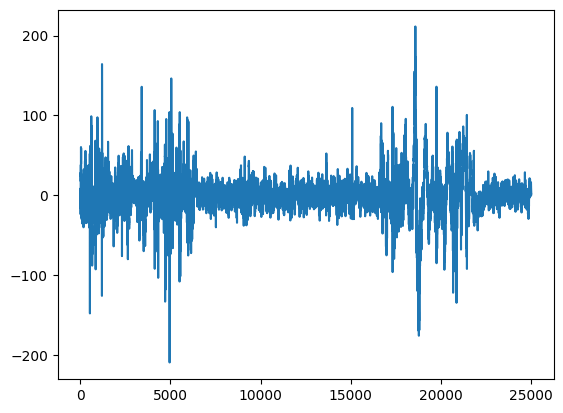

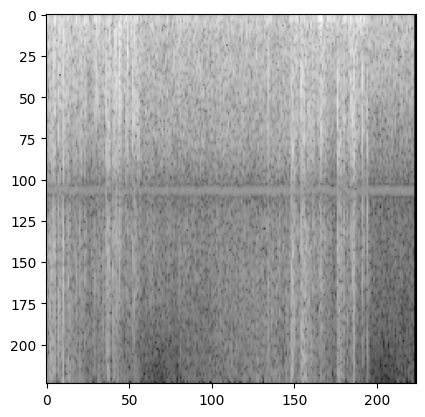

In [227]:
i = 15
plt.plot(dataset[i][0][0, 0, :])
plt.show()
plt.imshow(tensor_wt[i, 0, :, :], cmap='gray')

## Getting the embedding of the image using a pretrained ViT

In [92]:
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [124]:
pil_image.size

(224, 224)

In [125]:
inputs = processor(pil_image, return_tensors="pt", padding=True)

In [220]:
outputs = model(tensor_wt)

In [222]:
outputs[0][:, 0, :].shape

torch.Size([16, 768])